In [ ]:
# onion stuff, in response to j kenji lopez alt's post about how the best
# way to cut an onion with most uniform pieces is 60 percent of the way down
# my intuition is that it is 170 percent of the way down.
# heres some tests.
# also sorry to anyone reading this : i currently have a 7 week old that takes up most of my time
#
# https://www.instagram.com/p/CV6L30MBFy8/    <--- in response to this post
# matt sandler - 2021
# mishugana@gmail.com

import pandas as pd
import numpy as np
import math
import shapely
from shapely.geometry.point import Point
from shapely.geometry import Polygon
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

circRadius = 100 # i dunno this doesnt really matter anyway
pi = 3.14159 # close enough
totalCircleArea = pi * (circRadius ** 2)
rings = 11 # usually between 8 and 13
percentDown = 60 # this is kenji's claim
slices = 7 # how any times are we going to cut this onion

In [ ]:
def getOnionSTD(percentDown = percentDown, rings = rings, slices = slices, draw=False):
    ringSpacing = circRadius / (rings+1) # assume evenly distributed rings
    ringSpaces = np.arange(ringSpacing, circRadius + ringSpacing, ringSpacing).tolist()
    percentDown = percentDown / 100.0
    shapelyCircles = []
    for ringSpace in ringSpaces:
        p = Point(0, 0)
        shapelyCircle = p.buffer(ringSpace)
        shapelyCircles.append(shapelyCircle)
    for x in range(len(shapelyCircles)-1,0,-1):
        shapelyCircles[x] = shapelyCircles[x].difference(shapelyCircles[x-1])

    shapelyAreas = [shapelyCircle.area for shapelyCircle in shapelyCircles]

    lowerMatch = (totalCircleArea * 0.998)
    upperMatch = (totalCircleArea * 1.002)

    assert(lowerMatch <= shapelyCircle.area <= upperMatch)
    assert(lowerMatch <= sum(shapelyAreas) <= upperMatch)

    #cut this onion into a quarter
    quarterCut = Polygon([[0, 0], [circRadius, 0], [circRadius, circRadius], [0, circRadius]])
    quarterCircleArea = totalCircleArea / 4.0

    quarteredOnion = []
    for shapelyCircle in shapelyCircles:
        quarteredOnion.append(shapelyCircle.intersection(quarterCut))

    lowerMatchq = (quarterCircleArea * 0.998)
    upperMatchq = (quarterCircleArea * 1.002)

    quarteredAreas = [qO.area for qO in quarteredOnion]
    assert(lowerMatchq <= sum(quarteredAreas) <= upperMatchq)


    thetas = [i * 90/(slices+1) for i in range(slices + 1)]
    thetaRanges = []
    for i, theta in enumerate(thetas):
        if i+1 == len(thetas):
            thetaRanges.append([theta,90])
        else:
            thetaRanges.append([theta,thetas[i+1]])

    #slice it up
    shapelySlices = []
    for thetaRange in thetaRanges:
        #making it much bigger because why not,
        #still should work for the intersection slice

        circX0 = (circRadius * 1.01) * math.cos((90-thetaRange[0]) * 0.0174532925)
        circY0 = (circRadius * 1.01) * math.sin((90-thetaRange[0]) * 0.0174532925)

        circX1 = (circRadius * 1.01) * math.cos((90-thetaRange[1]) * 0.0174532925)
        circY1 = (circRadius * 1.01) * math.sin((90-thetaRange[1]) * 0.0174532925)

        sliceX = 0
        sliceY = -(percentDown * circRadius)
        shapelySlice = Polygon([[sliceX,sliceY],[circX0,circY0],[circX1,circY1],[sliceX,sliceY] ])
        shapelySlices.append(shapelySlice)

    onionPieces = []

    for onionRing in quarteredOnion:
        for shapelySlice in shapelySlices:
            if onionRing.intersects(shapelySlice):
                cutPiece = onionRing.intersection(shapelySlice)
                if draw:
                  plt.plot(*cutPiece.exterior.xy)
                onionPieces.append(cutPiece)
    onionAreas = [onionPiece.area for onionPiece in onionPieces]
    # print(onionAreas)
    assert(lowerMatchq <= sum(onionAreas) <= upperMatchq)
    # using coefficient of variation instead of just standard deviation because it makes more sense.
    return np.std(onionAreas) / np.mean(onionAreas)

0.3405532874424046

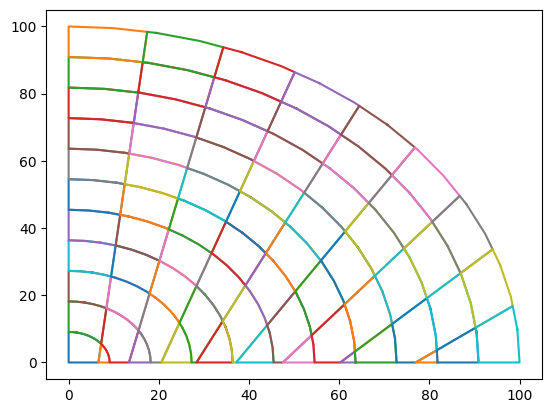

In [ ]:
#test
getOnionSTD(60, 10, 8, draw=True)

In [ ]:
# res = minimize(getOnionSTD, 60, method='TNC',
#                options={'disp': True}, bounds=[(0,100)], tol=1e-10)
# #theres not a gradient so this isnt very useful

In [ ]:
# pDowns = []
# sliceStds = []
# for ring in range(8,13):
#   for sliceNum in range(6,11):
#     res = dual_annealing(getOnionSTD,
#               args=(ring, sliceNum), bounds=[(0,100)])
#     pDown = res["x"][0]
#     sliceStd = res["fun"]
# #    print(f'At {ring} rings and {sliceNum} slices...')
# #    print(f'Cut {round(pDown,3)} percent down for {round(sliceStd,3)} std!' )
#     pDowns.append(pDown)
#     sliceStds.append(sliceStd)

In [ ]:
#brute force by 5s seems quickest (versus an optimizer for this problem)
pDowns = []
sliceStds = []
for ring in range(7,13):
  for sliceNum in range(6,12):
    percentResults = [(percent,getOnionSTD(percent,ring,sliceNum)) for  percent in range(0,200,1)]
    best = min(percentResults, key = lambda t: t[1])
    print(f'At {ring} rings and {sliceNum} slices...')
    print(f'\tCut percent down: \n\t\t {round(best[0],3)}%\n\tfor std of:\n\t\t{round(best[1],3)}' )
    pDowns.append(best[0])
    sliceStds.append(best[1])

At 7 rings and 6 slices...
	Cut percent down: 
		 124%
	for std of:
		0.304
At 7 rings and 7 slices...
	Cut percent down: 
		 172%
	for std of:
		0.204
At 7 rings and 8 slices...
	Cut percent down: 
		 131%
	for std of:
		0.299
At 7 rings and 9 slices...
	Cut percent down: 
		 113%
	for std of:
		0.3
At 7 rings and 10 slices...
	Cut percent down: 
		 101%
	for std of:
		0.301
At 7 rings and 11 slices...
	Cut percent down: 
		 92%
	for std of:
		0.301
At 8 rings and 6 slices...
	Cut percent down: 
		 97%
	for std of:
		0.31
At 8 rings and 7 slices...
	Cut percent down: 
		 129%
	for std of:
		0.293
At 8 rings and 8 slices...
	Cut percent down: 
		 172%
	for std of:
		0.199
At 8 rings and 9 slices...
	Cut percent down: 
		 133%
	for std of:
		0.285
At 8 rings and 10 slices...
	Cut percent down: 
		 116%
	for std of:
		0.295
At 8 rings and 11 slices...
	Cut percent down: 
		 105%
	for std of:
		0.305
At 9 rings and 6 slices...
	Cut percent down: 
		 109%
	for std of:
		0.329
At 9 rings an

In [ ]:
print(f'Percent Down\n \tmean : \t{round(np.mean(pDowns),3)}\n\tmin : \t{round(np.min(pDowns),3)}\n\tmax : \t{round(np.max(pDowns),3)}\t ')
print(f'Standard Deviation\n \tmean : \t{round(np.mean(sliceStds),3)}\n\tmin : \t{round(np.min(sliceStds),3)}\n\tmax : \t{round(np.max(sliceStds),3)}\t ')

Percent Down
 	mean : 	121.75
	min : 	67
	max : 	173	 
Standard Deviation
 	mean : 	0.28
	min : 	0.194
	max : 	0.329	 


0.33868840261323113

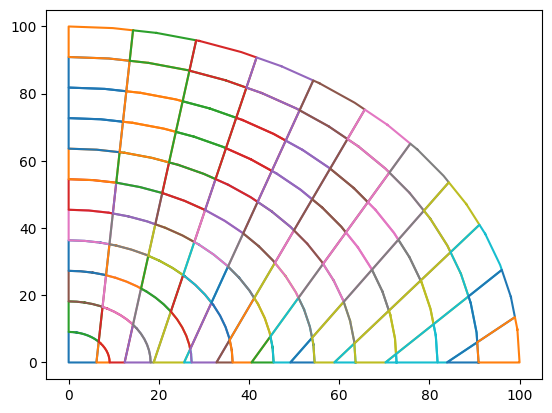

In [ ]:
getOnionSTD(75,10,10,draw=True)

0.33868840261323113

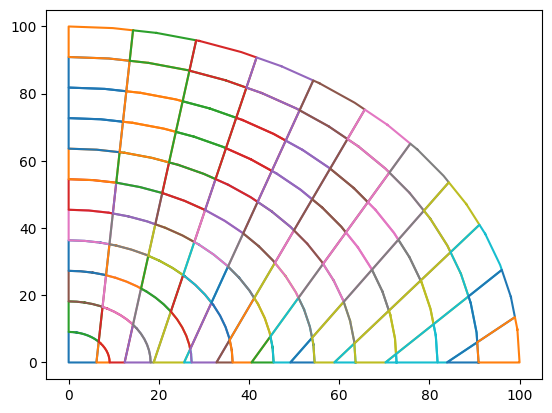

In [ ]:
getOnionSTD(75,10,10,draw=True)

0.287137470930199

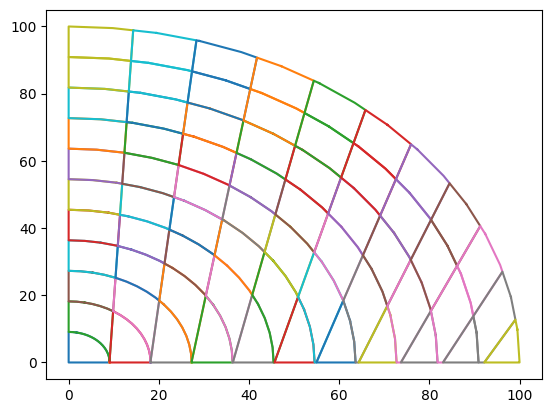

In [ ]:
getOnionSTD(170,10,10,draw=True)

In [ ]:
testRings = 10
testSlices = 10
print(f'Mean results from brute force \t\t\t\t{round(getOnionSTD(np.mean(pDowns),testRings,testSlices),4)}')
print(f'An early guess \t\t\t\t\t\t{round(getOnionSTD(75,testRings,testSlices),4)}')
print(f'Mathematical hunch for equal slice to ring ratio \t{round(getOnionSTD(170,testRings,testSlices),4)}')
print(f'Kenjis guess \t\t\t\t\t\t{round(getOnionSTD(60,testRings,testSlices),4)}')


Mean results from brute force 				0.3606
An early guess 						0.3387
Mathematical hunch for equal slice to ring ratio 	0.2871
Kenjis guess 						0.3732


In [ ]:
testRings = 10
testSlices = 7
print(f'Mean results from brute force \t\t\t\t{round(getOnionSTD(np.mean(pDowns),testRings,testSlices),4)}')
print(f'An early guess \t\t\t\t\t\t{round(getOnionSTD(75,testRings,testSlices),4)}')
print(f'Mathematical hunch for equal slice to ring ratio \t{round(getOnionSTD(170,testRings,testSlices),4)}')
print(f'Kenjis guess \t\t\t\t\t\t{round(getOnionSTD(60,testRings,testSlices),4)}')

Mean results from brute force 				0.3573
An early guess 						0.3845
Mathematical hunch for equal slice to ring ratio 	0.364
Kenjis guess 						0.3818


In [ ]:
np.mean(pDowns)

121.75